# ECG Classification – Modeling
EDA 전처리를 기반으로 **ECG 파형(0=Normal, 1=Abnormal)** 분류 모델을 학습한다.  
클래스 불균형을 고려해 **class_weight='balanced'** 를 사용하고, **ROC-AUC·F1-score** 중심으로 평가한다.

### 주요 단계
1. 데이터 로드 & 학습/검증/테스트 분리 (60/20/20, stratify)
2. 스케일링 (Logistic 전용)
3. 베이스라인 모델 (Logistic Regression)
4. 추가 모델 (Random Forest)
5. 성능 평가 (Accuracy, F1, ROC-AUC)
6. 시각화 (혼동행렬, ROC Curve)

In [27]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix, ConfusionMatrixDisplay, roc_curve, auc

# 1) 데이터 불러오기
X = pd.read_csv("../data/X_processed.csv")
y = pd.read_csv("../data/y_processed.csv")["label"]

print("X:", X.shape, "| y:", y.shape)

X: (109446, 187) | y: (109446,)


In [28]:
# 2) Train/Val/Test 분할
X_train, X_temp, y_train, y_temp = train_test_split(
    X, y, test_size=0.4, stratify=y, random_state=42
)
X_val, X_test, y_val, y_test = train_test_split(
    X_temp, y_temp, test_size=0.5, stratify=y_temp, random_state=42
)

print("Train:", X_train.shape, "Val:", X_val.shape, "Test:", X_test.shape)

Train: (65667, 187) Val: (21889, 187) Test: (21890, 187)


In [29]:
# 3) 스케일링 (Logistic)
scaler = StandardScaler() # 4) Logistic Regression 학습 및 검증 평가
X_train_sc = scaler.fit_transform(X_train)
X_val_sc   = scaler.transform(X_val)
X_test_sc  = scaler.transform(X_test)

In [32]:
# 4) 모델 학습
logreg = LogisticRegression(class_weight="balanced", max_iter=1000, random_state=42)
rf     = RandomForestClassifier(class_weight="balanced", n_estimators=300, random_state=42)

logreg.fit(X_train_sc, y_train)
rf.fit(X_train, y_train)

# Validation 예측
y_val_pred_lr = logreg.predict(X_val_sc)
y_val_pred_rf = rf.predict(X_val)

print("LogReg  | Acc:", accuracy_score(y_val, y_val_pred_lr), "F1:", f1_score(y_val, y_val_pred_lr))
print("RF      | Acc:", accuracy_score(y_val, y_val_pred_rf), "F1:", f1_score(y_val, y_val_pred_rf))

LogReg  | Acc: 0.8439855635250583 F1: 0.6327562103451984
RF      | Acc: 0.9776143268308283 F1: 0.931237721021611


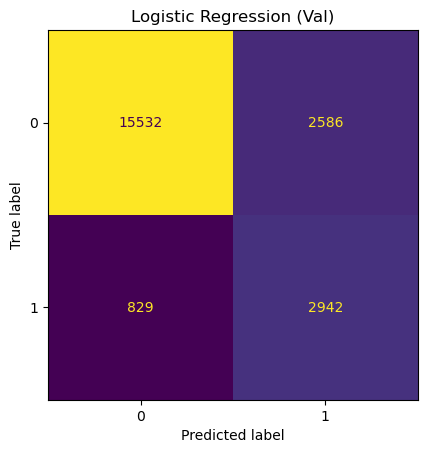

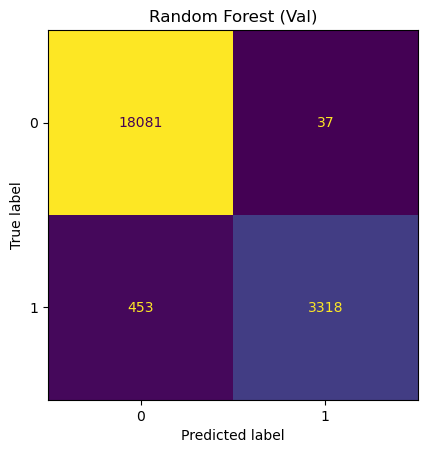

In [33]:
# Confusion Matrix - Logistic Regression
ConfusionMatrixDisplay(confusion_matrix(y_val, y_val_pred_lr)).plot(colorbar=False)
plt.title("Logistic Regression (Val)")
plt.savefig("../figures/confmat_logreg.png", dpi=150, bbox_inches="tight")
plt.show()

# Confusion Matrix - Random Forest
ConfusionMatrixDisplay(confusion_matrix(y_val, y_val_pred_rf)).plot(colorbar=False)
plt.title("Random Forest (Val)")
plt.savefig("../figures/confmat_rf.png", dpi=150, bbox_inches="tight")
plt.show()

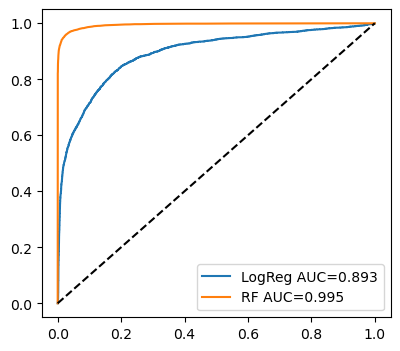

In [34]:
# 6) ROC Curve
plt.figure(figsize=(4.5,4))
fpr, tpr, _ = roc_curve(y_val, logreg.predict_proba(X_val_sc)[:,1])
plt.plot(fpr, tpr, label=f"LogReg AUC={auc(fpr,tpr):.3f}")
fpr, tpr, _ = roc_curve(y_val, rf.predict_proba(X_val)[:,1])
plt.plot(fpr, tpr, label=f"RF AUC={auc(fpr,tpr):.3f}")
plt.plot([0,1],[0,1],'k--')
plt.legend()
plt.savefig("../figures/roc_logreg_rf.png", dpi=150, bbox_inches="tight")
plt.show()

In [35]:
# 7) Test 평가
f1_lr = f1_score(y_val, y_val_pred_lr)
f1_rf = f1_score(y_val, y_val_pred_rf)
best = "LogReg" if f1_lr >= f1_rf else "RF"

if best == "LogReg":
    y_pred = logreg.predict(X_test_sc)
else:
    y_pred = rf.predict(X_test)

print("Final Model:", best)
print("Test Acc:", accuracy_score(y_test, y_pred))
print("Test F1 :", f1_score(y_test, y_pred))

Final Model: RF
Test Acc: 0.9757423481041572
Test F1 : 0.9252428551316345


## 모델링 결과 요약 — Logistic Regression vs Random Forest

### 데이터/전처리
- MIT-BIH + PTBDB 기반 이진 분류 (0=Normal, 1=Abnormal)  
- 결측치/무한값 → 0으로 대체  
- 분할: Stratified 60/20/20  
- Logistic Regression: 입력 특성 표준화(StandardScaler)  

### 지표 (Validation set)
- **Logistic Regression**  
  - Accuracy: 0.844  
  - F1-score: 0.633  
  - ROC-AUC: 0.893  

- **Random Forest**  
  - Accuracy: 0.978  
  - F1-score: 0.931  
  - ROC-AUC: 0.995  

### 지표 (Test set, Final Model = RF)
- Accuracy: 0.976  
- F1-score: 0.925  

### 산출물
- 혼동행렬: `../figures/confmat_logreg.png`, `../figures/confmat_rf.png`  
- ROC 곡선: `../figures/roc_logreg_rf.png`  

### 해석
- Logistic Regression은 baseline으로 성능 확보 가능하나, 심전도의 복잡한 패턴을 단순 선형 경계로는 충분히 반영하지 못해 Abnormal 탐지율이 낮음.
- Random Forest는 **파형의 다양한 특징(진폭 변화, 불규칙성 등)을 포착**하여 Accuracy/F1/ROC-AUC가 우수하였고, 불균형 데이터에도 강건함.
- **Validation과 Test 성능이 유사**하여 과적합 없이 안정적으로 일반화됨을 확인.
- 최종 모델은 **Random Forest**로 선택. (향후: 하이퍼파라미터 튜닝, 필요 시 CNN으로 원시 신호/특성 확장)